# Elastic Datashader
This notebook demonstrates a method to combine the powerful datashader library with data stored in ElasticSearch.  Instead of trying to extract all the points from ElasticSearch via `scan()`, which can be slow, it uses `geotile_grid` aggregations with a twist.  Normally an aggregation can only produce 10,000 buckets (unless you increase this setting in on the server) so in Kibana you get views like this.

![title](img/map.png)

The alternative is to sub-divided the query up into one or more independent sub-queries that each use a higher `geotile_grid` aggregation precision than would otherwise be possible.


This notebook requires additional packages installed, which can be accomplished the following Dockerfile.

```
FROM jupyter/datascience-notebook

USER root

RUN apt-get update && \
    apt-get install -y --no-install-recommends \
      libgeos-dev \
      libproj-dev \
      llvm-7-dev \
      proj-bin

USER $NB_UID

RUN conda install --quiet --yes \
    'colorcet' \
    'datashader' \
    'mercantile' \
    'holoviews' \
    && \
    conda clean --all -f -y && \
    fix-permissions $CONDA_DIR && \
    fix-permissions /home/$NB_USER

RUN pip install 'geoviews' 'elasticsearch' 'elasticsearch_dsl'
```

# Preliminaries
Install packages and define some utility functions.

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
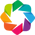

In [49]:
import os
import math
import logging
import functools
import multiprocessing
import multiprocessing.dummy
import mercantile
import pandas as pd
import numpy as np
import datashader as ds
import colorcet as cc
import datashader.transfer_functions as tf
import geoviews as gv
import geoviews.feature as gf
import geoviews.tile_sources as gts
import holoviews as hv
from holoviews.operation.datashader import datashade, spread, dynspread
from holoviews import streams
from elasticsearch.client import Elasticsearch
from elasticsearch import TransportError
from elasticsearch_dsl import Search, Q, A
from elasticsearch_dsl.aggs import Bucket

gv.extension('bokeh')

In [2]:
# Patch elasticsearch_dsl
class GeotileGrid(Bucket):
    name = 'geotile_grid'


## Utility Functions

In [50]:
def poly2bbox(poly):
    xs, ys = poly.array().T
    return mercantile.LngLatBbox(xs[0], ys[0], xs[2], ys[2])

def get_bbox():
    box_stream = globals().get("box_stream")
    if not box_stream:
        # Return essentially the entire world
        return mercantile.LngLatBbox(-180, -83, 180, 83)
    else:
        polygons = box_stream.element.split()
        bboxes = [ poly2bbox(p) for p in polygons ]
        if len(bboxes) > 1:
            logging.warning("get_bbox() only supports one box")
        return bboxes[0]

## Get the bounding box to query
Use the map to draw the box area you want to query.  Select box edit mode (i.e. the box with the plus button) then press and hold shift while drawing the box.

In [51]:
bbox = get_bbox()
initial_box = hv.Bounds( (bbox.west, bbox.south, bbox.east, bbox.north) )
box_poly = gv.Polygons( [initial_box] )
box_stream = streams.BoxEdit(source=box_poly, num_objects=1)
(gts.CartoDark * box_poly).opts(
    hv.opts.Polygons(fill_alpha=0, line_color='white', selection_fill_color='red'),
    hv.opts.WMTS(width=800, height=500, global_extent=True)
)

:Overlay
   .WMTS.I     :WMTS   [Longitude,Latitude]
   .Polygons.I :Polygons   [Longitude,Latitude]

# Subdivide the query area into subqueries
If you simply query the entire area, you will have very limited resolution in your datashader plot because the maximum number of bins ElasticSearch support (by default) is 10,000.  The alternative is to perform many smaller queries over the area of interest.

In [52]:
def iter_all_tiles(zz, bbox=None):
    if bbox is None:
        for xx in range(2*zz):
            for yy in range(2*zz):
                yield mercantile.Tile(xx, yy, zz)
    else:
        for tile in mercantile.tiles(bbox.west, bbox.south, bbox.east, bbox.north, zz, True):
            yield tile
    
def num_tiles(zz, bbox=None):
    """
    Determine how many tiles are contained within the bbox at a given zoom level
    """
    if bbox is None:
        return 2**zz
    else:
        return sum(1 for _ in iter_all_tiles(zz, bbox))

def estimate_maximum_tilezoom(bbox=None, max_tiles=2048, max_zoom=29):
    """
    For a given bounding box, estimate the zoom level that can
    be used without exceeding max_tiles
    """
    
    if bbox is None:
        # The number of tiles at zoom-level zz would be
        #     num_tiles = 2^zz * 2^zz = 2^(2*zz)
        # Solving for zz you get
        #     zz = log_2(num_tiles) / 2
        zz = int(math.log(max_tiles, 2) / 2)
        ntiles = num_tiles(zz)
        return zz, ntiles
    else:
        # If there is a bounding box, find the smallest tile that contains it to
        # pick a starting zoom
        bbox_tile = mercantile.bounding_tile(bbox.west, bbox.south, bbox.east, bbox.north)
        zz = bbox_tile.z
        ntiles = 1
        # iterate from the starting zoom to find the highest zoom achieveable
        for zz in range(zz, max_zoom):
            tt = num_tiles(zz, bbox)
            if tt > max_tiles:
                zz -= 1 # back off one zoom level
                break
            ntiles = tt
            
        return zz, ntiles
    

## Preview the query boxes
You don't need to run this cell, but it helps visualize what the query will look like

In [53]:
bbox = get_bbox()
zz, tt = estimate_maximum_tilezoom(bbox)
print(f"The bounding box will be divded into {tt} tiles at zoom level {zz}")

query_boxes = []
for tile in iter_all_tiles(zz, bbox):
    bb = mercantile.bounds(tile)
    query_box = hv.Bounds( (bb.west, bb.south, bb.east, bb.north) )
    query_boxes.append(query_box)
    
query_poly = gv.Polygons(query_boxes)
(gts.CartoDark * query_poly).opts(
    hv.opts.Polygons(fill_alpha=0, line_color='white', selection_fill_color='red'),
    hv.opts.WMTS(width=800, height=500, global_extent=True)
)

The bounding box will be divded into 1394 tiles at zoom level 14


:Overlay
   .WMTS.I     :WMTS   [Longitude,Latitude]
   .Polygons.I :Polygons   [Longitude,Latitude]

In [54]:
def convert_response(response):
    if hasattr(response.aggregations, 'categories'):
        for category in response.aggregations.categories:
            for bucket in category.grids:
                yield dict(
                    lon=bucket.centroid.location.lon,
                    lat=bucket.centroid.location.lat,
                    c=bucket.centroid.count,
                    t=str(category.key)
                )
    else:
        for bucket in response.aggregations.grids:
            yield dict(
                lon=bucket.centroid.location.lon,
                lat=bucket.centroid.location.lat,
                c=bucket.centroid.count
            )

def count_terms(index, bbox, query=None, geopoint_field="location", term_field=None):
    s = Search(index=index).using(ES).filter(
        "geo_bounding_box",
        **{
            geopoint_field: {
                "top_left": {
                    "lat": bbox.north,
                    "lon": bbox.south
                },
                "bottom_right": {
                    "lat": bbox.south,
                    "lon": bbox.east
                }
            }
        }
    ).extra(
        size=0
    )
    
    if query:
        s = s.query(query)
        
    s.aggs.metric(
        'term_count',
        'cardinality',
        field=term_field
    )
        
    response = s.execute()

    return response.aggregations.term_count.value
        
def query_tile(index, precision, tile, query=None, geopoint_field="location", term_field=None):
    bbox = mercantile.bounds(tile)
    
    ES = Elasticsearch(timeout=300)

    s = Search(index=index).using(ES).filter(
        "geo_bounding_box",
        **{
            geopoint_field: {
                "top_left": {
                    "lat": bbox.north,
                    "lon": bbox.south
                },
                "bottom_right": {
                    "lat": bbox.south,
                    "lon": bbox.east
                }
            }
        }
    ).extra(
        size=0
    )
    
    if query:
        s = s.query(query)
    
    if term_field:
        s.aggs.bucket(
            'categories',
            'terms',
            field=term_field,
        ).bucket(
            'grids',
            'geotile_grid',
            field=geopoint_field,
            precision=precision,
        ).metric(
            'centroid',
            'geo_centroid',
            field=geopoint_field
        )
    else:
        s.aggs.bucket(
            'grids',
            'geotile_grid',
            field=geopoint_field,
            precision=precision
        ).metric(
            'centroid',
            'geo_centroid',
            field=geopoint_field
        )
        
    try:
        response = s.execute()
    except TransportError as e:
        logging.info("%s", s.to_dict())
        return None
    else:
        df = pd.DataFrame(convert_response(response))
        if len(df) > 0:
            df.loc[:, 'x'], df.loc[:, 'y'] = ds.utils.lnglat_to_meters(df.lon, df.lat)

        return df
  
def build_dataframe(index, zoom_level, bbox, query=None, precision=None, geopoint_field="location", term_field=None):

    max_bins = 10000
    
    # Count the terms to figure out how many grid bins we can tolerate
    if term_field is not None:
        term_count = count_terms(
            index,
            bbox,
            query=query,
            geopoint_field=geopoint_field,
            term_field=term_field
        )
        
        # Reduce 
        if term_count >= 1:
            max_bins = int(max_bins / term_count) - 1
        
    # we don't know how dense/sparse the data will be
    # so we preform the query at a precision that
    # guarantees that even if every bin were filled
    # we would have less than max_bins, if you know your data
    # is sparse you could be more aggressive here
    if precision is None:
        zoom_inc = int(math.log(max_bins, 2) / 2)
        precision = zoom_level + zoom_inc
        
    with multiprocessing.Pool(multiprocessing.cpu_count()) as pool:
    
        dfs = pool.map(
            functools.partial(
                query_tile,
                index,
                precision,
                query=query,
                geopoint_field=geopoint_field,
                term_field=term_field
            ),
            iter_all_tiles(zoom_level, bbox)
        )
    
    df = pd.concat( filter(lambda x: x is not None, dfs) )
    
    if term_field and getattr(df, 't', None) is not None:
        df['t'] = df.t.astype('category')

    return df

# Perform the query

In [55]:
bbox = get_bbox()
zz, tt = estimate_maximum_tilezoom(bbox)
df = build_dataframe(
    "nyc-taxi",
    zz,
    bbox,
    geopoint_field='pickup_location'
)
df

lon        lat  c             x             y
0   -74.139582  40.809303  1 -8.253181e+06  4.984254e+06
1   -74.147644  40.797982  1 -8.254078e+06  4.982589e+06
0   -74.143148  40.765798  1 -8.253578e+06  4.977858e+06
0   -74.145789  40.753077  1 -8.253872e+06  4.975988e+06
0   -74.139582  40.809303  1 -8.253181e+06  4.984254e+06
..         ...        ... ..           ...           ...
101 -74.000702  40.680561  1 -8.237721e+06  4.965338e+06
102 -74.001291  40.680441  1 -8.237786e+06  4.965321e+06
103 -74.002517  40.680496  1 -8.237923e+06  4.965328e+06
104 -74.005823  40.680125  1 -8.238291e+06  4.965274e+06
105 -74.009712  40.680029  1 -8.238724e+06  4.965260e+06

[1052970 rows x 5 columns]

# Render the Datashader Image

In [56]:
def create_color_key(categories, cmap='glasbey_category10'):
    # The global color_key stores all colors assigned to keys
    # so that the same color is always used for a given category
    # even in cases between successive runs
    _color_key = globals().setdefault('_color_key', dict())
    
    color_key = {}
    for k in categories:
        # Set the global color key for this category
        ii = len(_color_key)
        palette_color = cc.palette[cmap][ii % len(cc.palette[cmap])]
        color = _color_key.setdefault(
            k,
            palette_color
        )
        # Return the local color key
        color_key[k] = color
        
    return color_key

def render_image(df, spread=None, cmap=None):
    # For small data sets, unless spread was explicitly
    # turned off, turn it on
    if len(df) < 100000 and spread is None:
        spread = True
    
    if cmap == None:
        # BKR was chosen because both low-density and high-density
        # areas are visible on a black background
        cmap = cc.bkr 
        
    
    if getattr(df, 't', None) is not None:
        min_alpha=150 # personal preference
        color_key = create_color_key(df.t.dtypes.categories)
        agg = ds.count_cat('t')
    else:
        min_alpha = None
        color_key = None
        agg = ds.sum('c')
        
        
    canvas = ds.Canvas()
    
    agg = canvas.points(
        df,
        'x',
        'y',
        agg=agg
    )
    
    img = tf.shade(
        agg,
        cmap=cmap,
        color_key=color_key,
        min_alpha=min_alpha
    )
    
    img = tf.set_background(img, 'black')
    
    if spread:
        img = tf.dynspread(
            img,
            max_px=10
        )
        
    return img

def render_map(df, spread=None, cmap=None):
    # For small data sets, unless spread was explicitly
    # turned off, turn it on
    if len(df) < 100000 and spread is None:
        spread = True
    
    if cmap == None:
        # BKR was chosen because both low-density and high-density
        # areas are visible on a black background
        cmap = cc.bkr 
        
    
    if getattr(df, 't', None) is not None:
        min_alpha=150 # personal preference
        color_key = create_color_key(df.t.dtypes.categories)
        agg = ds.count_cat('t')
    else:
        min_alpha = None
        color_key = None
        agg = ds.sum('c')
        
        
    points = hv.Points(
        df,
        ['x', 'y']
    )
    
    img = datashade(
        points,
        aggregator=agg,
        cmap=cmap,
        color_key=color_key,
        min_alpha=min_alpha
    )
        
    if spread:
        img = dynspread(
            img,
            max_px=10
        )
        
    # make a few hidden points at the bottom to create a legend
    legend = None
    if color_key:
        categories = []
        for category in df.t.dtypes.categories:
            categories.append((
                df[df.t == category].sum()['c'],
                category,
                color_key[category]
            ))
        categories.sort(key=lambda x: x[0], reverse=True)
        
        legend = hv.NdOverlay(
            { k: hv.Points(ds.utils.lnglat_to_meters(-179.99,-89.99), label=str(k)).opts(color=v)
              for (_, k, v) in categories
            }
        )
        
    return img, legend

# Render the Datashader Image

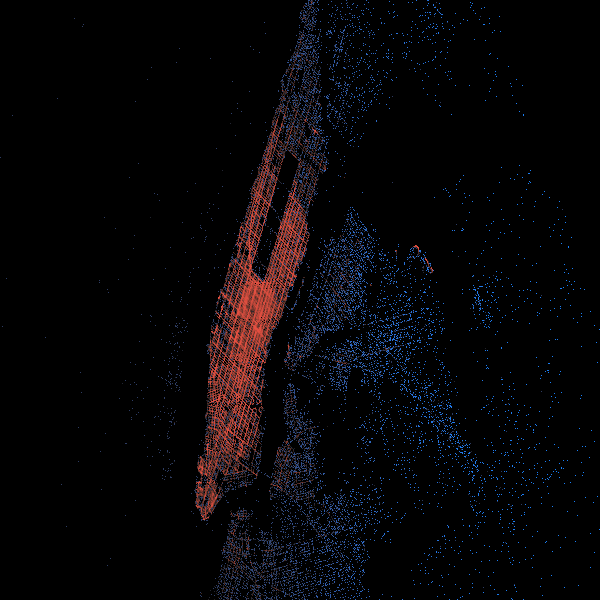

In [57]:
render_image(df)

# Render Map

In [58]:
img, colors = render_map(df)

if colors is not None:
    Map = (gts.CartoDark * img * colors).opts(
        hv.opts.WMTS(width=800, height=500, global_extent=True)
    )
else:
    Map = (gts.CartoDark * img).opts(
        hv.opts.WMTS(width=800, height=500, global_extent=True)
    )
Map

:DynamicMap   []
   :Overlay
      .WMTS.I :WMTS   [Longitude,Latitude]
      .RGB.I  :RGB   [x,y]   (R,G,B,A)

# Color by a term

In [59]:
bbox = get_bbox()
zz, tt = estimate_maximum_tilezoom(bbox)

df = build_dataframe(
    "nyc-taxi",
    zz,
    bbox,
    geopoint_field='pickup_location',
    term_field='passenger_count'
)
df

lon        lat  c  t             x             y
0   -74.139582  40.809303  1  1 -8.253181e+06  4.984254e+06
1   -74.147644  40.797982  1  1 -8.254078e+06  4.982589e+06
0   -74.143148  40.765798  1  1 -8.253578e+06  4.977858e+06
0   -74.145789  40.753077  1  1 -8.253872e+06  4.975988e+06
0   -74.139582  40.809303  1  1 -8.253181e+06  4.984254e+06
..         ...        ... .. ..           ...           ...
106 -73.983751  40.680506  1  4 -8.235834e+06  4.965330e+06
107 -73.996804  40.680302  1  4 -8.237287e+06  4.965300e+06
108 -74.001084  40.680612  1  4 -8.237763e+06  4.965345e+06
109 -73.808602  40.680200  1  6 -8.216336e+06  4.965285e+06
110 -74.009483  40.680179  1  6 -8.238698e+06  4.965282e+06

[994330 rows x 6 columns]

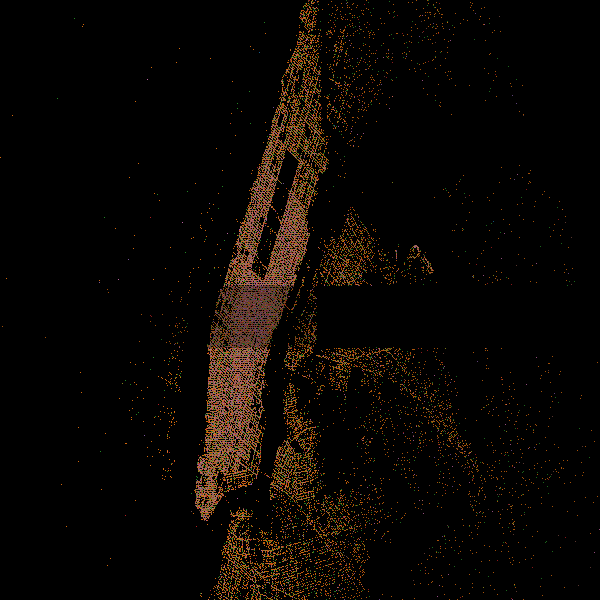

In [60]:
render_image(df)

In [61]:
img, legend = render_map(df)

if legend is not None:
    Map = (gts.CartoDark * img * legend).opts(
        hv.opts.WMTS(width=800, height=500, global_extent=True)
    )
else:
    Map = (gts.CartoDark * img).opts(
        hv.opts.WMTS(width=800, height=500, global_extent=True)
    )
Map

:DynamicMap   []
   :Overlay
      .WMTS.I        :WMTS   [Longitude,Latitude]
      .RGB.I         :RGB   [x,y]   (R,G,B,A)
      .NdOverlay.A_0 :NdOverlay   [Element]
         :Points   [x,y]